In [1]:
from pie_data import PIE
import numpy as np
import os

In [2]:
path = os.getcwd()
pie = PIE(data_path=path)
# 1 second = 30 frames
db = pie.generate_database()

---------------------------------------------------------
Generating database for pie
pie annotations loaded from /home/arash/PedVid/PIE/data_cache/pie_database.pkl


In [3]:
data_opts = {'fstride': 3 ,   #0.1 sec
             'sample_type': 'all',
             'height_rng': [0, float('inf')],
             'squarify_ratio': 0,
             'data_split_type': 'default',  # kfold, random, default
             'seq_type': 'crossing',
             'min_track_size': 21,
             'random_params': {'ratios': None,
                             'val_data': True,
                             'regen_data': True}}#,
             #'kfold_params': {'num_folds': 4, 'fold': 2}}

In [19]:
beh_seq = pie.generate_data_trajectory_sequence('all', **data_opts)
#beh_seq_2 = pie.generate_data_trajectory_sequence('test', **data_opts)

---------------------------------------------------------
Generating trajectory sequence data
fstride: 3
sample_type: all
height_rng: [0, inf]
squarify_ratio: 0
data_split_type: default
seq_type: crossing
min_track_size: 21
random_params: {'ratios': None, 'val_data': True, 'regen_data': True}
kfold_params: {'num_folds': 5, 'fold': 1}
---------------------------------------------------------
Generating database for pie
pie annotations loaded from /home/arash/PedVid/PIE/data_cache/pie_database.pkl
---------------------------------------------------------
Generating crossing data
Subset: all
Number of pedestrians: 1842 
Total number of samples: 517 


In [56]:
ky = list((beh_seq).keys())
ky

['image',
 'pid',
 'bbox',
 'center',
 'age',
 'gender',
 'intersection',
 'num_lanes',
 'signalized',
 'direction',
 'obd_speed',
 'gps_coord',
 'intention_prob',
 'activities',
 'image_dimension']

In [199]:
# change format for aux-LSTM
userXtraj, userYtraj = [],[]
veh_speed,useraux = [],[]
time_traj = []
for i in range(len(beh_seq['pid'])):
    
    if (beh_seq['intersection'][i][0][0] > 0) or \
    (beh_seq['signalized'][i][0][0] > 1):    #limit to midblock unsignalized
            continue
    stop = len(beh_seq['pid'][i])
    times = np.linspace(0,stop,stop)/10
    time_traj.append(times)
    xy = np.array(beh_seq['center'][i])
    sp = np.array(beh_seq['obd_speed'][i])
    userXtraj.append(xy[:,0])
    userYtraj.append(xy[:,1])
    veh_speed.append(sp[:,0])
    int_speed = sp[:,0][0] * 3.6 #km/h initial speed of vehicle
    oneway, twoway = 0, 0
    if beh_seq['direction'][i][0][0] == 0:
        oneway = 1
    else:
        twoway = 1
    
    num_lanes = beh_seq['num_lanes'][i][0][0]
    
    aux = np.array([oneway, twoway, int_speed, num_lanes])
    useraux.append(aux)
  

    

In [200]:
import pandas as pd
#check for ouliers
dur=[]
for i in range(len(time_traj)):
    t = time_traj[i][-1]
    dur.append(t)

dur=pd.DataFrame(dur,columns=['duration'])

dur.describe()

,duration
count,49.000000
mean,10.779592
std,30.406797
min,3.200000
25%,4.400000
50%,5.500000
75%,7.500000
max,218.300000


(array([40.,  6.,  2.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         1.]),
 array([  3.2   ,   8.5775,  13.955 ,  19.3325,  24.71  ,  30.0875,
         35.465 ,  40.8425,  46.22  ,  51.5975,  56.975 ,  62.3525,
         67.73  ,  73.1075,  78.485 ,  83.8625,  89.24  ,  94.6175,
         99.995 , 105.3725, 110.75  , 116.1275, 121.505 , 126.8825,
        132.26  , 137.6375, 143.015 , 148.3925, 153.77  , 159.1475,
        164.525 , 169.9025, 175.28  , 180.6575, 186.035 , 191.4125,
        196.79  , 202.1675, 207.545 , 212.9225, 218.3   ]),
 <a list of 40 Patch objects>)

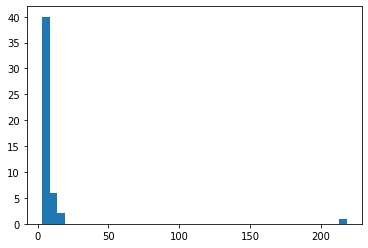

In [201]:
import matplotlib.pyplot as plt
plt.hist(dur.iloc[:,0],bins=40)

In [202]:
#indices of experiments when it takes more than ~15 seconds  to cross.
# 2 rows out of total 49 removed
out=dur[dur['duration']>15].index

for i in sorted(out,reverse=True): #reverse is true to make sure indices does not change after removing
    del userXtraj[i]
    del userYtraj[i]
    del useraux[i]
    del time_traj[i]
    del veh_speed[i]
    
out = dur[dur['duration']>15].index



In [221]:
# Data Normalization
# normalization using min max method
    
maxX = max(map(max, userXtraj))
minX = min(map(min, userXtraj))

maxY = max(map(max, userYtraj))
minY = min(map(min, userYtraj))

maxS = max(map(max, veh_speed))
minS = min(map(min, veh_speed))

Xscaled=[]
Yscaled=[]
Sscaled=[]
for i in range(len(userXtraj)):
    if userXtraj[i][0]>userXtraj[i][-1]:  #make 0 of X axis = ped starting side
        Xscaled.append(1 -(userXtraj[i]-minX)/(maxX-minX))
    else:
        Xscaled.append((userXtraj[i]-minX)/(maxX-minX))
        
    Yscaled.append((userYtraj[i]-minY)/(maxY-minY))
    Sscaled.append((veh_speed[i]-minS)/(maxS-minS))
    

Xscaled=np.array(Xscaled)
Yscaled=np.array(Yscaled)
Sscaled=np.array(Sscaled)
useraux=np.array(useraux)

/home/arash/.local/lib/python3.6/site-packages/ipykernel_launcher.py:26: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/home/arash/.local/lib/python3.6/site-packages/ipykernel_launcher.py:27: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/home/arash/.local/lib/python3.6/site-packages/ipykernel_launcher.py:28: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creatin

In [222]:
### Seperating test set before any modeling
import random
import pickle

tst=0.2                 #% test data

tstsize = int(np.floor(len(Xscaled) * tst))

#valsize = int(np.floor(len(X) * val))

tstlabel = random.sample(range(0, (len(Xscaled)-1)), len(range(tstsize)))

XscaledTest = Xscaled[tstlabel]
YscaledTest = Yscaled[tstlabel]
SscaledTest = Sscaled[tstlabel]
userauxTest = useraux[tstlabel]

trnlabel=[i for i in range(len(Xscaled)) if i not in tstlabel]

XscaledTrain = Xscaled[trnlabel]
YscaledTrain = Yscaled[trnlabel]
SscaledTrain = Sscaled[trnlabel]
userauxTrain = useraux[trnlabel]


# Saving files to drive
folder = '/home/arash/PedVid/PIE/seqdata/'

with open(f'{folder}XscaledTrain', 'wb') as f:
     pickle.dump(XscaledTrain, f)

with open(f'{folder}YscaledTrain', 'wb') as f:
     pickle.dump(YscaledTrain, f)

with open(f'{folder}SscaledTrain', 'wb') as f:
    pickle.dump(SscaledTrain, f)
        
with open(f'{folder}userauxTrain', 'wb') as f:
     pickle.dump(userauxTrain, f)
        
with open(f'{folder}XscaledTest', 'wb') as f:
     pickle.dump(XscaledTest, f)

with open(f'{folder}YscaledTest', 'wb') as f:
     pickle.dump(YscaledTest, f)

with open(f'{folder}SscaledTest', 'wb') as f:
    pickle.dump(SscaledTest, f)
        
with open(f'{folder}userauxTest', 'wb') as f:
     pickle.dump(userauxTest, f)

In [233]:
tt = 1 -(userXtraj[0]-minX)/(maxX-minX)